In [1]:
from __future__ import print_function

from misc.config import Config
from trainer import JoImTeR as trainer
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
from matplotlib import pyplot as plt
import cv2
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import pickle
import warnings
from tqdm import tqdm
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from PIL import Image
import datetime
import dateutil.tz
from misc.utils import mkdir_p
# from datasets import prepare_data
from model_phrase_cls import ImageEncoder_Classification
from dataset_mimic_cls import build_dataset
from misc.losses import words_loss,words_triplet_loss
from transformers import BertConfig
from misc.config import Config
import json
cfg = Config()

In [3]:
# proj_ds=pd.read_csv('../data/ChestXRay/dataset/indiana_projections.csv')
# repo_ds=pd.read_csv('../data/ChestXRay/dataset/indiana_reports.csv')


In [4]:
torch.cuda.set_device(2)
cudnn.benchmark = True

In [5]:
cfg.CUDA = True
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if cfg.CUDA:
    torch.cuda.manual_seed_all(cfg.seed)


In [6]:
### save cfg to log file ###
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
#     LAMBDA_FT,LAMBDA_FI,LAMBDA_DAMSM=01,50,10
output_dir = '../output/attnmaptest_%s_%s_%s'%(cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)
mkdir_p(output_dir)
cfg_log = os.path.join(output_dir, 'cfg.log')
with open(cfg_log, 'w') as f:
    json.dump(cfg.__dict__, f, indent=4)


data_set = build_dataset('train', cfg, output_dir)
print('Training set %d is loaded.' % len(data_set))
train_loader = torch.utils.data.DataLoader(
                data_set, batch_size=cfg.batch_size, drop_last=True,
                shuffle=True, num_workers=cfg.num_workers, pin_memory=True)

# data_set = dataset_mimic.build_dataset('train', cfg)
# test_loader = torch.utils.data.DataLoader(
#                 data_set, batch_size=100, drop_last=False,
#                 shuffle=False, num_workers=1)
data_iter = iter(train_loader)

Training set 217246 is loaded.


In [20]:

# bert_config = BertConfig(vocab_size=train_loader.dataset.vocab_size, hidden_size=512, num_hidden_layers=3,
#                     num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
#                     hidden_dropout_prob=cfg.hidden_dropout_prob, attention_probs_dropout_prob=cfg.attention_probs_dropout_prob,
#                     max_position_embeddings=512, layer_norm_eps=1e-12,
#                     initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

def build_model(cfg):
    image_encoder = ImageEncoder_Classification(num_class=train_loader.dataset.num_classes, 
                                                    encoder_path=cfg.init_image_encoder_path, pretrained=False, cfg = cfg)

    if cfg.text_encoder_path != '':

        img_encoder_path = cfg.text_encoder_path.replace('text_encoder', 'image_encoder')
#         print('Load image encoder from:', img_encoder_path)
        state_dict = torch.load(img_encoder_path, map_location='cpu')
        if 'model' in state_dict.keys():
            image_encoder.load_state_dict(state_dict['model'])
        else:
            image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters(): # make image encoder grad on
        p.requires_grad = False


    #         image_encoder.eval()
    epoch = 0

    ###################################################################
#     text_encoder = TextEncoder(bert_config = bert_config, output_channels=cfg.hidden_dim)
#     if cfg.text_encoder_path != '':
#         text_encoder_path = cfg.text_encoder_path
# #         print('Load text encoder from:', text_encoder_path)
#         state_dict = torch.load(text_encoder_path, map_location='cpu')
#         if 'model' in state_dict.keys():
#             text_encoder.load_state_dict(state_dict['model'])
#         else:
#             text_encoder.load_state_dict(state_dict)
#     for p in text_encoder.parameters(): # make text encoder grad on
#         p.requires_grad = False

    # ########################################################### #
    if cfg.CUDA:
#         text_encoder = text_encoder.cuda()
        image_encoder = image_encoder.cuda()
    return image_encoder.eval()

In [235]:
model_path = '/media/My1TBSSD1/IPMI2021/output/MIMIC_class_ft_sa_2021_03_09_18_07_58/Model/image_encoder15.pth'

In [236]:
cfg.text_encoder_path = model_path
image_encoder = build_model(cfg)


In [237]:
# text_encoder

In [238]:
data_iter = iter(train_loader)

In [314]:
imgs, classes, uids = data_iter.next()


In [315]:
if cfg.CUDA:
    imgs, classes, uids = imgs.cuda(), classes.cuda(), uids.cuda()
     

In [316]:
# class_ids = class_ids.numpy()

In [317]:
# labels = Variable(torch.LongTensor(range(train_loader.batch_size))) # used for matching loss
        
# if cfg.CUDA:
#     labels = labels.cuda()

In [318]:
# ids = np.array(list(range(train_loader.batch_size)))
# neg_ids = Variable(torch.LongTensor([np.random.choice(ids[ids!=x]) for x in ids])) # used for matching loss
                
# neg_ids = neg_ids.cuda()
# neg_ids

In [319]:
# a,b,c, \
# d,e = [1,2,3,4,5]
data_set.idx_to_class

{0: 'Atelectasis',
 1: 'Cardiomegaly',
 2: 'Consolidation',
 3: 'Edema',
 4: 'Enlarged Cardiomediastinum',
 5: 'Fracture',
 6: 'Lung Lesion',
 7: 'Lung Opacity',
 8: 'No Finding',
 9: 'Pleural Effusion',
 10: 'Pleural Other',
 11: 'Pneumonia',
 12: 'Pneumothorax',
 13: 'Support Devices'}

In [320]:
# array[:2]

def getDataWithClass(classes, uids, required_class = None):
    c = classes.detach().cpu().numpy()
    u = uids.detach().cpu().numpy()
    
    c_id = data_set.class_to_idx[required_class]
    
    x = np.where(np.argmax(c,-1) == c_id)
    return x, u[x]

train_loader.batch_size


32

In [339]:
getDataWithClass(classes, uids, required_class='Cardiomegaly')

((array([24, 26]),), array([59190650, 57027620]))

In [340]:
preds, attn_maps_l4, learnable_scalar_l4, attn_maps_l5, learnable_scalar_l5 = image_encoder(imgs)
# w_feats,  bigram_embs, trigram_embs, s_feats = text_encoder(captions,masks)

In [341]:
# loss0, loss1, att_maps = words_loss(r_feats,w_feats[:,:,1:],labels, cap_lens-1, class_ids, train_loader.batch_size)

In [342]:
# loss0_t, loss1_t, att_maps = words_triplet_loss(r_feats,w_feats[:,:,1:],labels, neg_ids, cap_lens-1, train_loader.batch_size)

In [354]:
idx = 26 #69
indexes = list(range(14))
classes[idx].detach().cpu().numpy(),uids[idx]


(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       dtype=float32),
 tensor(57027620, device='cuda:2'))

In [355]:
attn_maps_l4[idx].shape

torch.Size([1, 32, 32])

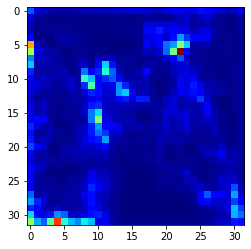

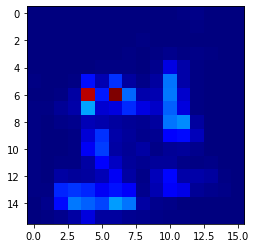

In [356]:
mapsl4 = attn_maps_l4[idx][0].detach().cpu().numpy()
plt.imshow(mapsl4, alpha=1, cmap='jet')
plt.show()

mapsl5 = attn_maps_l5[idx][0].detach().cpu().numpy()
plt.imshow(mapsl5, alpha=1, cmap='jet')
plt.show()

In [357]:
# pd.options.display.max_colwidth = 0
# repo_ds[repo_ds.uid==class_ids[idx]]

In [358]:
# sent_tokens = np.array([data_set.idx2word[x] for x in captions[idx][:masks[idx].sum()].detach().cpu().numpy()])[1:]

In [359]:
# ' '.join(sent_tokens)

In [360]:
imgs_selected = imgs.detach().cpu().numpy()

In [361]:
imgs_selected = (imgs_selected[idx][0]+1)/2
imgs_selected.min(),imgs_selected.max()

(0.19999999, 0.8509804)

In [362]:
# i = 0
# for attn_map in att_maps[idx][0].detach().cpu().numpy():
#     print(sent_tokens[i])
#     plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
#     plt.imshow(cv2.resize(attn_map,(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
#     plt.show()
#     i+=1


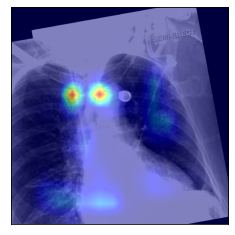

In [363]:


plt.imshow(imgs_selected, alpha=1, cmap='gray')
plt.imshow(cv2.resize(mapsl5,(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
# for i in range(1, columns*rows +1):
# #     print(i)
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
#     plt.imshow(cv2.resize(maps[i-1],(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
#     ax[-1].set_title(sent_tokens[i-1])
# #     plt.show()
plt.show()

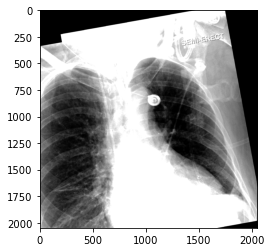

In [364]:
plt.imshow(imgs_selected,cmap='gray')

In [365]:
#59922421,51109744, 50649804

In [366]:
# with open('../../MIMIC-CXR/lm_reports/mimic_dataset_mit_normalized.pkl', 'rb') as f:
#     d = pickle.load(f)
uids[idx]

tensor(57027620, device='cuda:2')

In [367]:
d['data_dict'][uids[idx].detach().cpu().tolist()]

{'filenames': ['files/p12/p12077313/s57027620/0a98384b-609813c2-7d64896c-ba672ebf-e79efffe.dcm',
  'files/p12/p12077313/s57027620/8fee0cbe-6855fb99-362bfac2-82226dd6-15609179.dcm'],
 'text': 'As compared to the previous radiograph , no relevant change is seen . The monitoring and support devices are constant . Moderate cardiomegaly . No evidence of pneumonia , pulmonary edema or pleural effusions .',
 'split': 0,
 'official_split': 0,
 'token_ids': [1,
  119,
  120,
  95,
  22,
  279,
  225,
  6,
  555,
  128,
  5,
  61,
  22,
  561,
  43,
  560,
  562,
  45,
  768,
  316,
  333,
  6,
  129,
  40,
  111,
  54,
  131,
  11,
  9,
  284,
  2]}

In [282]:
uids[idx].detach().cpu().tolist()

54284690